In [10]:
# base code from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html#training

import gym
import gym.wrappers.monitoring.video_recorder

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from  collections import deque
from itertools import count
from PIL import Image

import atari_wrappers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as Tf
from tqdm import tqdm

torch.cuda.empty_cache()
torch.set_printoptions(edgeitems=5)

In [11]:
# env = gym.make('Breakout-v4')#.unwrapped
# env = gym.make('Gravitar-v0').unwrapped
# game = 'BreakoutNoFrameskip-v4'
game = 'GravitarNoFrameskip-v0'
game= 'PongNoFrameskip-v0'

In [12]:
# Wrappers
video_every=5
env = atari_wrappers.make_atari(game)
env = gym.wrappers.Monitor(env, "./recordings/"+game+'/', video_callable=lambda episode_id: (episode_id%video_every)==0,force=True)
env = atari_wrappers.wrap_deepmind(env,episode_life=False,clip_rewards=False,frame_stack=True)
# env = atari_wrappers.wrap_deepmind(env,episode_life=True,clip_rewards=False,frame_stack=True)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
# Replay memory class, storing states, actions, following state and the reward gained

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))
Sequence = namedtuple('Sequence',('transitions','recurrent_state'))

class ReplayMemory(object):

    def __init__(self, capacity, files):
        self.files = files
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.priorities = np.zeros(capacity)
        self.alpha = 0.6

    def push(self, seq):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = seq
        self.priorities[self.position] = 1
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def PERSample(self,batch_size, beta =0.6):
        # beta chanegs over time
        #Can change to use sum-tree
        if len(self.memory) < self.capacity:
            tmpPriorities = self.priorities[:self.position]
        else:
            tmpPriorities = self.priorities

        #priority_j ^alpha / sum priorities
        probs = tmpPriorities**self.alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probs)
        tmpPriorities = tmpPriorities[indices]
        loss_weights = (len(tmpPriorities)*tmpPriorities/len(self.memory))**(-beta)
        loss_weights /= loss_weights.max()

        return [self.memory[index] for index in indices], indices, loss_weights

    def updatePriorities(self, indices, newPriorities):
        for i in range(len(indices)):
            self.priorities[indices[i]] = newPriorities[i]

    def __len__(self):
        return len(self.memory)

In [14]:
# Number of Linear input connections depends on output of conv2d layers
# and therefore the input image size, so compute it.
def conv2d_size_out(size, kernel_size = 5, stride = 2):
    return (size - (kernel_size - 1) - 1) // stride  + 1


class DuelingLSTMDQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DuelingLSTMDQN, self).__init__()
        if scaledScreenSize[1] > 80:
            conv_out = 64
            # Hyper parameters from Rainbow paper - https://arxiv.org/pdf/1710.02298.pdf
            if grey:
                self.conv1 = nn.Conv2d(1*4, 32, kernel_size=8, stride=4)
            else:
                self.conv1 = nn.Conv2d(3*4, 32, kernel_size=8, stride=4)
            self.bn1 = nn.BatchNorm2d(32)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
            self.bn2 = nn.BatchNorm2d(64)
            self.conv3 = nn.Conv2d(64, conv_out, kernel_size=3, stride=1)
            self.bn3 = nn.BatchNorm2d(conv_out)
            convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,kernel_size=8,stride=4),kernel_size=4),kernel_size=3,stride=1)
            convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,kernel_size=8,stride=4),kernel_size=4),kernel_size=3,stride=1)

        else: # scaledScreenSize[0] == 64:
            # for reduced model complexity
            conv_out = 32
            if grey:
                self.conv1 = nn.Conv2d(1*4, 16, kernel_size=6, stride=3)
            else:
                self.conv1 = nn.Conv2d(3*4, 16, kernel_size=6, stride=3)
            self.bn1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
            self.bn2 = nn.BatchNorm2d(32)
            self.conv3 = nn.Conv2d(32, conv_out, kernel_size=3, stride=1)
            self.bn3 = nn.BatchNorm2d(conv_out)
            convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,kernel_size=6,stride=3),kernel_size=4),kernel_size=3,stride=1)
            convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,kernel_size=6,stride=3),kernel_size=4),kernel_size=3,stride=1)


        lstm_input_size = convw * convh * conv_out
        self.linear_input_size = 512
        # linear_input_size = convw * convh * conv_out


        self.lstm = nn.LSTMCell(lstm_input_size, self.linear_input_size)
        self.hiddenStatesBatch = torch.zeros(BATCH_SIZE,self.linear_input_size).to(device)
        self.cellStatesBatch = torch.zeros(BATCH_SIZE,self.linear_input_size).to(device)
        self.hiddenStatesLive = torch.zeros(1,self.linear_input_size).to(device)
        self.cellStatesLive = torch.zeros(1,self.linear_input_size).to(device)

        # dualing networks
        # https://arxiv.org/pdf/1511.06581.pdf
        self.adv1 = nn.Linear(self.linear_input_size, 512)
        self.adv2 = nn.Linear(512, outputs)
        self.val1 = nn.Linear(self.linear_input_size, 512)
        self.val2 = nn.Linear(512, 1)
        nn.init.kaiming_normal_(self.adv1.weight)
        nn.init.kaiming_normal_(self.val1.weight)

    def reset(self,done, batch=False):
        if batch:
            self.hiddenStatesBatch.detach()
            self.cellStatesBatch.detach()
            if done:
                self.hiddenStatesBatch = self.hiddenStatesBatch.zero_()
                self.cellStatesBatch = self.hiddenStatesBatch.zero_()
        else:
            self.hiddenStatesLive.detach()
            self.cellStatesLive.detach()
            if done:
                self.hiddenStatesLive = self.hiddenStatesLive.zero_()
                self.cellStatesLive = self.hiddenStatesLive.zero_()

    def getState(self, batch=False):
        if batch:
            # print(self.hiddenStatesBatch.detach().clone().cpu())
            # print( self.cellStatesBatch.detach().clone().cpu())
            return self.hiddenStatesBatch.detach().clone().cpu(), self.cellStatesBatch.detach().clone().cpu()
        else:
            # print(self.hiddenStatesLive.detach().clone().cpu())
            # print( self.cellStatesLive.detach().clone().cpu())
            return self.hiddenStatesLive.detach().clone().cpu(), self.cellStatesLive.detach().clone().cpu()

    def setState(self, state,device, batch=False):
        if batch:
            hiddens, cells = state
            self.hiddenStatesBatch = hiddens.clone().to(device)
            self.cellStatesBatch = cells.clone().to(device)
        else:
            hiddens, cells = state
            self.hiddenStatesLive = hiddens.clone().to(device)
            self.cellStatesLive = cells.clone().to(device)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x, hiddenState=None, cellState=None):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.contiguous().view(x.size(0), -1)
        if not(hiddenState==None):
            # print(x.shape,hiddenState.shape,cellState.shape)
            self.hiddenStatesLive, self.cellStatesLive = self.lstm(x,(hiddenState,cellState))
            # print('Forward single ',self.hiddenStatesLive.shape)
            # print(self.cellStatesLive.shape)
            adv = F.relu(self.adv1(self.hiddenStatesLive))
            val = F.relu(self.val1(self.hiddenStatesLive))

        else:
            # print(x.shape,self.hiddenStatesBatch.shape,self.cellStatesBatch.shape)
            self.hiddenStatesBatch, self.cellStatesBatch = self.lstm(x,(self.hiddenStatesBatch,self.cellStatesBatch))
            # print('Forward batch',self.hiddenStatesBatch.shape)
            # print(self.cellStatesBatch.shape)
            adv = F.relu(self.adv1(self.hiddenStatesBatch))
            val = F.relu(self.val1(self.hiddenStatesBatch))

        adv = self.adv2(adv)
        val = self.val2(val)
        return val + adv - adv.mean(1, keepdim=True)

    def calcLoss(self,batch):
        copy = DuelingLSTMDQN(screen_height, screen_width, n_actions).to(device)
        copy.load_state_dict(self.state_dict())
        copy.eval()
        batch = Sequence(*zip(*batch))
        batch = Sequence(list(zip(*batch.transitions)),list(zip(*batch.recurrent_state)))
        # print(batch.recurrent_state[0])
        # print(batch.recurrent_state[0])
        # print(batch.recurrent_state[1])
        # Needs checking
        hiddenStates = torch.cat(batch.recurrent_state[0])
        cellStates = torch.cat(batch.recurrent_state[1])

        # print(hiddenStates)

        self.setState((hiddenStates,cellStates),device,True)
        target_net.setState((hiddenStates,cellStates),device,True)

        #burn in the model
        with torch.no_grad():
            for t in range(n_burn_in):
                tmpTransition = Transition(*zip(*batch.transitions[t]))
                state = get_screen(tmpTransition.state,True).to(device)
                self.forward(state)
                target_net.forward(state)
            copy.setState(self.getState(True),device,True)
            for t in range(n_burn_in,n_burn_in+n_step_return):
                tmpTransition = Transition(*zip(*batch.transitions[t]))
                state = get_screen(tmpTransition.state,True).to(device)
                copy.forward(state)
                target_net.forward(state)
        self.reset(False,True)
        delta = torch.zeros(len(batch.transitions)-n_burn_in-n_step_return,BATCH_SIZE,1,device=device)
        # print(delta.shape,len(batch.transitions)-n_burn_in-n_step_return,)
        with torch.set_grad_enabled(True):
            for t in range(n_burn_in,len(batch.transitions)-n_step_return):
                tmpTransition = Transition(*zip(*batch.transitions[t]))
                nextTransition = Transition(*zip(*batch.transitions[t+n_step_return]))
                # print(tmpTransition)

                state_batch = get_screen(tmpTransition.state,True).to(device)
                action_batch = torch.cat(tmpTransition.action).to(device)
                reward_batch = torch.stack(tmpTransition.reward).to(device)
                next_state_batch = get_screen(nextTransition.state,True).to(device)
                done_batch = torch.stack(nextTransition.done).to(device)
                # print(state_batch.shape,action_batch.shape,reward_batch.shape,next_state_batch.shape,done_batch.shape)
                state_action_values = policy_net(state_batch)#.gather(1, action_batch)
                # print(state_action_values,state_action_values.gather(1, action_batch))
                state_action_values = state_action_values.gather(1,action_batch)
                actionPrediction = copy.forward(next_state_batch).argmax(dim=1).unsqueeze(1).detach()
                # print(actionPrediction)
                next_state_values = target_net(next_state_batch).gather(1, actionPrediction).detach()
                # print(next_state_values)
                # print(done_batch,reward_batch)
                expected_state_action_values = (self.inv_value_function(next_state_values) * GAMMA * (1.0 - done_batch)) \
                                           + reward_batch
                expected_state_action_values = self.value_function(expected_state_action_values)

                delta[t-n_burn_in] = F.smooth_l1_loss(state_action_values,expected_state_action_values.float(),reduction='none')

        # 0.9 is eta value
        # priorities = 0.9 * delta.max(dim=0)[0] + (1.0 - 0.9) * delta.mean(dim=0)
        # change this to be squared and decrease learning rate
        return delta.pow(2).sum(dim=0)#, priorities.detach()
        # return delta.sum(dim=0) #, priorities.detach()

    # https://arxiv.org/pdf/1805.11593.pdf
    def value_function(self,x,eps=1e-3):
        return x.sign() * ((x.abs()+1).sqrt()-1)+eps*x
    def inv_value_function(self,x,eps=1e-3):
        return x.sign() * ((((1+4*eps*(x.abs()+1+eps)).sqrt()-1) / (2 *eps)).pow(2)-1)



In [15]:
scaledScreenSize = (64,64)
# scaledScreenSize = (110,84)
grey = True
if grey:
    resize = T.Compose([T.ToPILImage(),
                        # T.Resize(scaledScreenSize, interpolation=Image.CUBIC),
                        # T.Grayscale(),
                        T.ToTensor()])
else:
    resize = T.Compose([T.ToPILImage(),
                        T.Resize(scaledScreenSize, interpolation=Image.CUBIC),
                        T.ToTensor()])

def get_screen(screen,batch=False):

    temp = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # BATCH,x,y,frame
    if batch:
        return torch.from_numpy(temp).permute(0,3,1,2)
    else:
        return torch.from_numpy(temp).unsqueeze(0).permute(0,3,1,2)


# temp = env.reset()
# env.step(0)
# env.step(0)
# plt.figure()
# if grey:
#     plt.imshow(get_screen(temp).cpu().permute(2,0,1)[0].numpy(),
#             interpolation='none', cmap='gray')
# else:
#     plt.imshow(get_screen(temp).cpu().permute(1, 2, 0).numpy(),
#             interpolation='none')
# plt.title('What the model Sees')
# plt.show()
#
# exit()

In [16]:
num_episodes = 10000
BATCH_SIZE = 20
GAMMA = 0.999**3
EPSILON_MAX=0.4
# EPSILON_MAX=0.1
EPSILON_MIN=0.01
TARGET_UPDATE = 5 # episodes
POLICY_UPDATE = 24 # frames
BETA_DECAY = num_episodes/10
EPS_DECAY=150
OUTPUT_FREQUENCY = 10
video_every=10
n_step_return = 3
n_sequence = 50 #size of LSTM
n_overlap = 25 #the next RNN state is half of the sequence length
n_burn_in = 30 #how many steps before RNN is set to actually update - ie gets better initial state

# update to 20 batch - 50 n_sequence, eps decay 150, eps max 0.4, episodic end of life = true -
# already made lr and loss power changes

# init with correct dims
if scaledScreenSize[1]==84:
    screen_width = 84
    screen_height = 84
else:
    screen_width = 64
    screen_height = 64

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DuelingLSTMDQN(screen_height, screen_width, n_actions).to(device)
target_net = DuelingLSTMDQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(),lr=7.5e-5,eps=1e-3)
capacity = 500
files = 10
memory = ReplayMemory(capacity=capacity,files=files)


def select_action(state,n_episode, LSTMState):
    # global steps_done
    sample = random.random()

    # reaches min in 2100 episodes
    epsilon = max( EPSILON_MAX * math.exp(-(n_episode/EPS_DECAY)), EPSILON_MIN)
    # gets to 30% in 600 episodes and starts at 0.8
    # epsilon = max(EPSILON_MIN,EPSILON_MAX - EPSILON_MIN*(n_episode/EPS_DECAY))

    if sample > epsilon:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            x = policy_net(get_screen(state).to(device),LSTMState[0].to(device),LSTMState[1].to(device))
            return x.max(1)[1].view(1, 1).cpu()
    else:
        return torch.tensor([[random.randrange(n_actions)]], device='cpu', dtype=torch.long)



In [17]:

def optimize_model(n_episode):

    beta = min(1, 0.4 + 1*(n_episode/BETA_DECAY))

    if len(memory) < BATCH_SIZE*2:
        return
    lossArr = []
    # BATCH SIZE is more like 32
    for _ in range(2):

        policy_net.reset(done=True,batch=True)
        # transitions = memory.sample(BATCH_SIZE)
        transitions = memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        delta = policy_net.calcLoss(transitions)
        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        # non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
        #                                       batch.next_state)), device=device, dtype=torch.bool)
        # non_final_next_states = torch.cat([s for s in batch.next_state
        #                                             if s is not None]).to(device)
        # state_batch = torch.cat(batch.state).to(device)
        # action_batch = torch.cat(batch.action)
        # reward_batch = torch.cat(batch.reward).to(device)
        # done_batch = torch.cat(batch.done).to(device)
        #
        # # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # # columns of actions taken. These are the actions which would've been taken
        # # for each batch state according to policy_net
        #
        # state_action_values = policy_net(state_batch).gather(1, action_batch)
        #
        # # Compute V(s_{t+1}) for all next states.
        # # Expected values of actions for non_final_next_states are computed based
        # # on the "older" target_net; selecting their best reward with max(1)[0].
        # # This is merged based on the mask, such that we'll have either the expected
        # # state value or 0 in case the state was final.
        # next_state_values = torch.zeros(BATCH_SIZE, device=device)
        #
        # next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        #
        # # Compute the expected Q values
        # expected_state_action_values = (next_state_values * GAMMA * (1.0 - done_batch)) \
        #                                + reward_batch
        # # Compute Huber loss
        # loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1), reduction='none')
        # # add little epsilon to make it not have p(s) = 0
        # priorities = (loss.abs() + 1e-5).detach()
        # memory.updatePriorities(indices,priorities)
        # loss = (delta * torch.tensor(np.expand_dims(loss_weights,1),dtype=torch.float).to(device)).mean().float()
        loss = (delta).mean().float()
        lossArr.append(loss.clone().detach().cpu().numpy())
        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        optimizer.step()
    return lossArr

In [18]:
#Training

seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

marking=[]
episodeScores=[]
losses = []
stepBuffer = deque(maxlen=n_step_return)
#precalculate GAMMA n step return values
gamma_nsteps = [GAMMA ** i for i in range(n_step_return+1)]
sequenceBuffer = []
recurrentBuffer = []
frames = 0
for n_episode in tqdm(range(num_episodes+1)):
    # print('New Episode')
    sequenceBuffer = []
    recurrentBuffer = []
    score=0
    # Initialize the environment and state
    state = env.reset()
    lives = env.ale.lives
    while True:
        recurrentBuffer.append(policy_net.getState())
        # print(recurrentBuffer[-1][0].shape,recurrentBuffer[-1][1].shape)
        # Select and perform an action
        action = select_action(state,n_episode,recurrentBuffer[-1])

        obvs, reward, done, info = env.step(action.item())
        score+=reward

        #Reward clipping and negative reward on death
        # if info['ale.lives'] != lives:
        #     reward-=1
        #     lives = info['ale.lives']
        # reward = np.clip(reward, -1, 1)
        reward = torch.tensor([reward])

        # Observe new state
        next_state = obvs
        if done:
            next_state = None

        stepBuffer.append(Transition(state,action,next_state,reward,torch.tensor([float(done)])))
        if len(stepBuffer) == stepBuffer.maxlen:
            reward_nstep = sum([gamma_nsteps[-(i+2)] * stepBuffer[i].reward for i in range(n_step_return)])
            sequenceBuffer.append(Transition(stepBuffer[0].state,stepBuffer[0].action,stepBuffer[0].next_state,reward_nstep,torch.tensor([float(done)])))
        if (len (sequenceBuffer)) == n_sequence+n_burn_in:
            memory.push(Sequence(sequenceBuffer,recurrentBuffer[0]))
            #chop sequence and recurrent buffers
            # print(len(sequenceBuffer[-(n_burn_in+n_overlap):]),len(recurrentBuffer[-(n_burn_in+n_overlap+n_step_return-1):]))
            sequenceBuffer = sequenceBuffer[-(n_burn_in+n_overlap):]
            recurrentBuffer = recurrentBuffer[-(n_burn_in+n_overlap+n_step_return):]
            # print(recurrentBuffer[0][0].shape,recurrentBuffer[0][1].shape)
        elif done and len(sequenceBuffer) > n_burn_in+n_overlap+n_step_return:
            # case of we're done so we push the rest of the sequence to memory
            # print(recurrentBuffer[0][0].shape,recurrentBuffer[0][1].shape)
            memory.push(Sequence(sequenceBuffer,recurrentBuffer[0]))

        if frames % POLICY_UPDATE == 0:
            x = optimize_model(n_episode)
            if x != None:
                losses += x

        # Move to the next state
        state = next_state
        frames+=1



        if done:
            stepBuffer.clear()

            break
    # Update the target network, copying all weights and biases in DQN
    if n_episode % TARGET_UPDATE == 0:
        torch.cuda.empty_cache()
        target_net.load_state_dict(policy_net.state_dict())
    episodeScores.append(int(score))
    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    if n_episode % OUTPUT_FREQUENCY == 0:
        if len(marking)>0:
            print("episode: {}, mean_last30: {:.2f}, mean_score: {:.2f}, std_score: {:.2f}, mean_loss: {:.4f}".format(
                n_episode, np.array(episodeScores[-30:]).mean(), np.array(marking).mean(), np.array(marking).std(),np.array(losses[-5:]).mean()),episodeScores[-OUTPUT_FREQUENCY:])



print('Complete')
# env.render()
env.close()


 16%|█▌        | 1582/10001 [84:49:38<451:25:48, 193.03s/it]


marking, episode: 0, score: -20.0, mean_score: -20.00, std_score: 0.00
episode: 10, mean_last30: -20.82, mean_score: -20.90, std_score: 0.30, mean_loss: 0.0084 [-21, -20, -21, -21, -21, -21, -21, -21, -21, -21]
episode: 20, mean_last30: -20.67, mean_score: -20.70, std_score: 0.56, mean_loss: 0.0037 [-20, -20, -21, -21, -21, -21, -20, -19, -21, -21]
episode: 30, mean_last30: -20.57, mean_score: -20.57, std_score: 0.67, mean_loss: 0.0015 [-20, -19, -21, -20, -20, -21, -21, -21, -19, -21]
episode: 40, mean_last30: -20.27, mean_score: -20.43, std_score: 0.77, mean_loss: 0.0019 [-19, -19, -21, -19, -20, -19, -21, -20, -21, -21]
episode: 50, mean_last30: -20.20, mean_score: -20.40, std_score: 0.80, mean_loss: 0.0017 [-20, -20, -18, -20, -21, -21, -20, -21, -21, -21]
episode: 60, mean_last30: -20.27, mean_score: -20.42, std_score: 0.76, mean_loss: 0.0024 [-20, -20, -21, -21, -21, -21, -20, -21, -20, -20]
episode: 70, mean_last30: -20.40, mean_score: -20.41, std_score: 0.73, mean_loss: 0.0014 

KeyboardInterrupt: 

Top 5 scores overall
[(1239, 21), (1274, 21), (980, 20), (997, 20), (1102, 20)]
Top videos:
[(980, 20), (1080, 19), (1230, 19), (1320, 19), (1240, 18), (1510, 18), (790, 17), (1390, 17), (1570, 17), (1580, 17)]
Bottom Videos
[(180, -21), (130, -21), (90, -21), (80, -21), (50, -21), (40, -21), (30, -21), (20, -21), (10, -21), (290, -20)]
Total Frames Trained on:  3577906


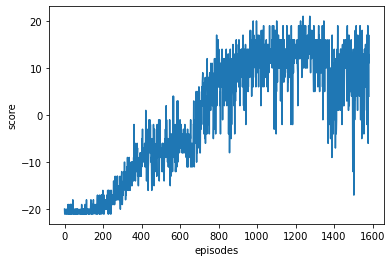

In [19]:
# Trend Graphs
episodeScoresEnum = sorted(enumerate(episodeScores),reverse=True,key=lambda x:x[1])
print('Top 5 scores overall')
print(episodeScoresEnum[:5])
tempScores = sorted([(i,j) for i,j in enumerate(episodeScores) if i%video_every==0],key=lambda x:x[1],reverse=True)
print('Top videos:')
print(tempScores[:10])
print('Bottom Videos')
print(tempScores[-10:][::-1])
print('Total Frames Trained on: ',frames)



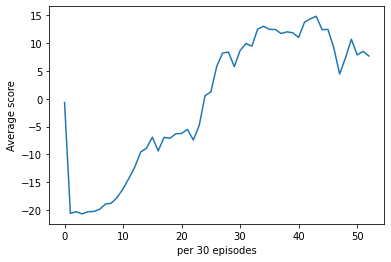

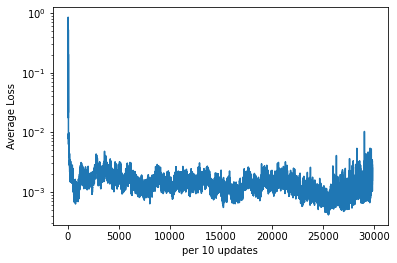

In [20]:
averages = []
tempAverage = 0
for i in enumerate(losses):
    tempAverage+=i[1]
    if i[0]%10==0:
        averages.append(tempAverage/10)
        tempAverage=0
plt.plot(range(len(averages)),averages)
plt.ylabel('Average Loss')
plt.yscale('log')
plt.xlabel('per 10 updates')
plt.show()

C:\Users\Julia\anaconda3\envs\DLRL-36\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
C:\Users\Julia\anaconda3\envs\DLRL-36\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Julia\anaconda3\envs\DLRL-36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  


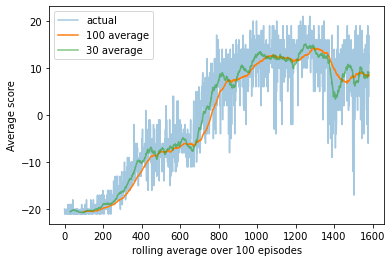

In [26]:
averages30 = []
averages = []

for i in range(len(episodeScores)):
    averages.append(np.array(episodeScores[i-100:i+1]).mean())
    averages30.append(np.array(episodeScores[i-30:i+1]).mean())

plt.plot(range(len(episodeScores)),episodeScores,alpha=0.4,label='actual')
plt.plot(range(len(averages)),averages,label='100 average')
plt.plot(range(len(averages30)),averages30,label='30 average',alpha=0.6)
plt.legend(loc='upper left')
plt.ylabel('Average score')
plt.xlabel('rolling average over 100 episodes')

plt.show()